In [315]:
import numpy as np
import pandas as pd

# give you file path here
dataset = pd.read_csv('OneDrive/Attachments/Telco-Customer-Churn.csv')

dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [316]:
print(dataset.isnull().sum())
print(dataset.describe())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64
       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000


Churn
No     5174
Yes    1869
Name: count, dtype: int64


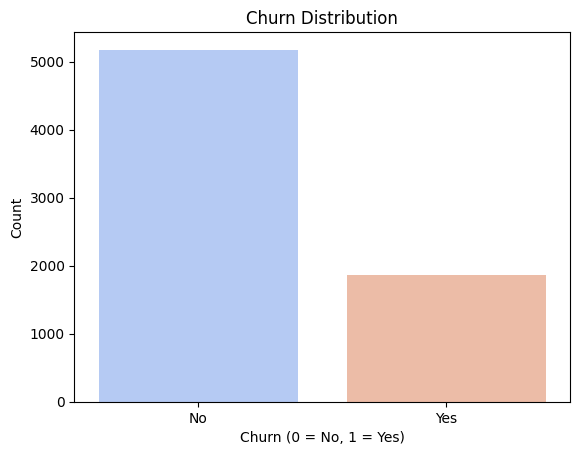

In [317]:
import seaborn as sns
import matplotlib.pyplot as plt

print(dataset['Churn'].value_counts())
sns.countplot(x='Churn', data=dataset, hue='Churn', palette='coolwarm', legend=False)
plt.title('Churn Distribution')
plt.xlabel('Churn (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

In [318]:
dataset['TotalCharges'] = pd.to_numeric(dataset['TotalCharges'], errors='coerce')
dataset['TotalCharges'] = dataset['TotalCharges'].fillna(dataset['TotalCharges'].median())

In [319]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
categorical_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 
                    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
                    'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']
for col in categorical_cols:
    dataset[col] = labelencoder.fit_transform(dataset[col])

In [320]:
from sklearn.model_selection import train_test_split

X = dataset.drop(['customerID', 'Churn'], axis=1)
y = dataset['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [321]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [322]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [323]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.79


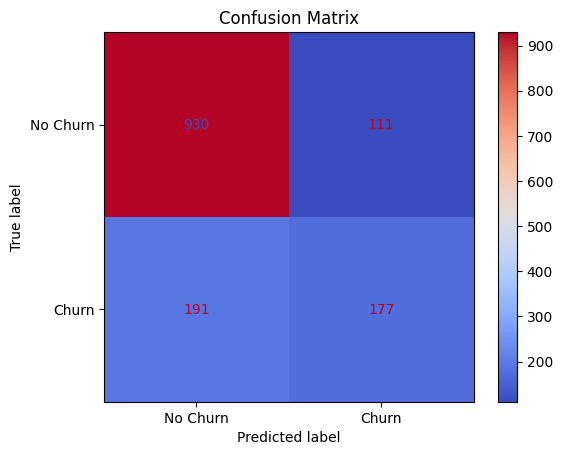

In [335]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn", "Churn"])
disp.plot(cmap="coolwarm")
plt.title('Confusion Matrix')
plt.show()

In [325]:
# Install eli5 if not already installed
# !pip install eli5  

import eli5
from eli5.sklearn import PermutationImportance


In [326]:
# Compute feature importance using permutation importance
perm = PermutationImportance(clf, random_state=42).fit(X_test, y_test)

# Show weights
eli5.show_weights(perm, feature_names=X.columns.tolist())


Weight,Feature
0.0250 ± 0.0129,tenure
0.0169 ± 0.0060,MonthlyCharges
0.0152 ± 0.0068,Contract
0.0102 ± 0.0041,TotalCharges
0.0094 ± 0.0096,PaperlessBilling
0.0078 ± 0.0075,gender
0.0053 ± 0.0034,SeniorCitizen
0.0053 ± 0.0050,PaymentMethod
0.0051 ± 0.0056,StreamingTV
0.0045 ± 0.0046,InternetService


Segment
Loyal      3295
Dormant    1913
At Risk    1835
Name: count, dtype: int64


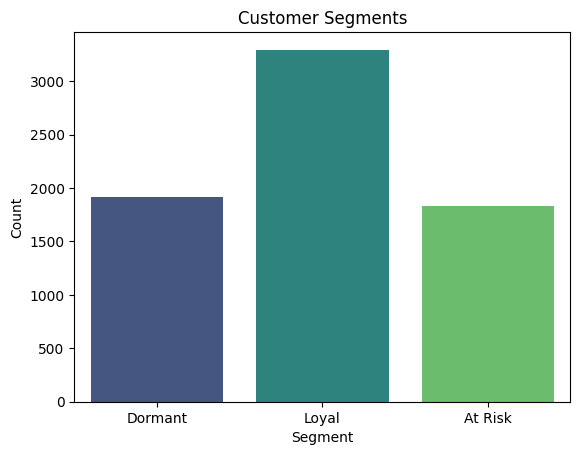

In [334]:
# Add predictions & probabilities to dataset
clf.fit(X, y)   # Make sure X is a DataFrame, not X.values
dataset['Churn_Prob'] = clf.predict_proba(X)[:,1]
dataset['Churn_Pred'] = clf.predict(X)

# Create Segments
def segment_customer(row):
    if row['Churn_Pred'] == 1 and row['Churn_Prob'] > 0.6:
        return "At Risk"    # Likely to churn
    elif row['Churn_Pred'] == 0 and row['tenure'] > 24:
        return "Loyal"      # Long tenure, not churning
    else:
        return "Dormant"    # Low tenure or uncertain case

dataset['Segment'] = dataset.apply(segment_customer, axis=1)

# Segment distribution
print(dataset['Segment'].value_counts())
sns.countplot(x='Segment', data=dataset, hue='Segment', palette='viridis', legend=False)
plt.title('Customer Segments')
plt.xlabel('Segment')
plt.ylabel('Count')
plt.show()
